In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00


In [2]:
import os, glob, math, random
import ast
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import torch
import pydicom
from scipy.ndimage import zoom
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# ========== 小物ユーティリティ ==========
def _iou_xyxy(a, b):
    # a,b: [x1,y1,x2,y2]
    x1 = max(a[0], b[0]); y1 = max(a[1], b[1])
    x2 = min(a[2], b[2]); y2 = min(a[3], b[3])
    iw = max(0.0, x2 - x1); ih = max(0.0, y2 - y1)
    inter = iw * ih
    if inter <= 0: return 0.0
    area_a = max(0.0, (a[2]-a[0]) * (a[3]-a[1]))
    area_b = max(0.0, (b[2]-b[0]) * (b[3]-b[1]))
    union = area_a + area_b - inter + 1e-9
    return inter / union

def _ensure_dir(p):
    Path(p).mkdir(parents=True, exist_ok=True)

# ========== 簡易 Weighted Boxes Fusion（クラス別） ==========
def weighted_boxes_fusion(
    boxes, scores, labels,
    iou_thr=0.55,
    conf_type="avg"   # "avg" か "one_minus_prod"
):
    """
    複数モデルの出力をマージ。boxes/scores/labels はすべて結合済み1配列（同一画像）。
    - boxes: (N,4) xyxy
    - scores: (N,)
    - labels: (N,)
    返り値: fused_boxes, fused_scores, fused_labels
    """
    if len(boxes) == 0:
        return boxes, scores, labels

    order = np.argsort(-scores)
    boxes = boxes[order]; scores = scores[order]; labels = labels[order]

    clusters = []  # list of dict: {'box': np.array(4), 'score_sum': float, 'scores': [..], 'label': int, 'weight_sum': float, 'members': int}
    for b, s, c in zip(boxes, scores, labels):
        matched = False
        for cl in clusters:
            if cl['label'] != c:
                continue
            if _iou_xyxy(b, cl['box']) >= iou_thr:
                # 既存クラスタにマージ（座標はスコア重みで移動平均）
                w_old = cl['weight_sum']; w_new = s
                cl['box'] = (cl['box'] * w_old + b * w_new) / (w_old + w_new + 1e-9)
                cl['weight_sum'] += w_new
                cl['scores'].append(s)
                cl['members'] += 1
                matched = True
                break
        if not matched:
            clusters.append({
                'box': b.copy(),
                'label': int(c),
                'weight_sum': float(s),
                'scores': [float(s)],
                'members': 1,
            })

    fused_boxes, fused_scores, fused_labels = [], [], []
    for cl in clusters:
        fused_boxes.append(cl['box'])
        if conf_type == "one_minus_prod":
            # 1 - ∏(1-s) で統合信頼度
            p = 1.0
            for s in cl['scores']:
                p *= (1.0 - s)
            sc = 1.0 - p
        else:
            sc = float(np.mean(cl['scores']))
        fused_scores.append(sc)
        fused_labels.append(cl['label'])

    return np.vstack(fused_boxes), np.array(fused_scores), np.array(fused_labels, dtype=int)

# ========== 1画像に対する fold アンサンブル推論 ==========
def predict_ensemble_single_image(
    models,
    image,
    conf=0.2,
    iou=0.7,
    imgsz=320,
    per_model_max_det=1,      # 各モデルが返す最大検出数
    ensemble_iou=0.55,          # WBF のクラスタ閾値
    only_one=True,             # True で最終1件に絞る
    agnostic=False,             # True でクラス無視の後段NMSをしたい場合（今回はWBFなので通常Falseのまま推奨）
):
    """
    各 fold の best.pt を読み、単一画像に対して推論→WBFで統合。
    戻り値: dict {'boxes': (K,4), 'scores': (K,), 'labels': (K,)}
    """
    # 遅延ロードを避けたい場合は、外で [YOLO(p) for p in model_paths] を渡す実装に変えてもOK
    boxes_all = []
    scores_all = []
    labels_all = []

    for model in models:
        model = YOLO(mp)
        res = model.predict(
            source=image,
            conf=conf, iou=iou, imgsz=imgsz, max_det=per_model_max_det, verbose=False
        )[0]
        if res.boxes is None or len(res.boxes) == 0:
            continue
        xyxy = res.boxes.xyxy.cpu().numpy()
        sco  = res.boxes.conf.cpu().numpy()
        lab  = (res.boxes.cls.cpu().numpy().astype(int)
                if res.boxes.cls is not None else np.zeros(len(xyxy), dtype=int))
        boxes_all.append(xyxy); scores_all.append(sco); labels_all.append(lab)

    if len(boxes_all) == 0:
        return {'boxes': np.zeros((0,4), dtype=np.float32),
                'scores': np.zeros((0,), dtype=np.float32),
                'labels': np.zeros((0,), dtype=np.int32)}

    boxes = np.vstack(boxes_all)
    scores = np.hstack(scores_all)
    labels = np.hstack(labels_all)

    # 簡易 WBF
    f_boxes, f_scores, f_labels = weighted_boxes_fusion(
        boxes, scores, labels, iou_thr=ensemble_iou, conf_type="one_minus_prod"
    )

    # 1件に絞る（スコア最大）
    if only_one and len(f_scores) > 0:
        idx = int(np.argmax(f_scores))
        f_boxes = f_boxes[idx:idx+1]
        f_scores = f_scores[idx:idx+1]
        f_labels = f_labels[idx:idx+1]

    return {'boxes': f_boxes, 'scores': f_scores, 'labels': f_labels}

# ========== ディレクトリ一括推論 & オーバーレイ保存 & CSV ==========
def ensemble_infer_dir(
    model_paths,
    images_root,
    out_dir="/kaggle/working/ens_out",
    conf=0.2,
    iou=0.7,
    imgsz=640,
    per_model_max_det=100,
    ensemble_iou=0.55,
    only_one=False,
    draw_score=True,
):
    """
    images_root 配下の *.png / *.jpg を再帰探索して、fold アンサンブル推論。
    - オーバーレイ画像を out_dir/overlays 下に保存（元のサブフォルダ構造を維持）
    - 予測座標を CSV に保存（out_dir/ensemble_predictions.csv）
    """
    images_root = Path(images_root)
    out_dir = Path(out_dir)
    overlays_dir = out_dir / "overlays"
    _ensure_dir(overlays_dir)

    img_paths = (list(images_root.rglob("*.png")) +
                 list(images_root.rglob("*.jpg")) +
                 list(images_root.rglob("*.jpeg")))
    img_paths.sort()
    if not img_paths:
        print(f"No images found under: {images_root}")
        return None

    rows = []
    # フォント（環境によっては使えないことがあるので None でフォールバック）
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", size=14)
    except:
        font = None

    for img_path in img_paths:
        pred = predict_ensemble_single_image(
            model_paths, str(img_path),
            conf=conf, iou=iou, imgsz=imgsz,
            per_model_max_det=per_model_max_det,
            ensemble_iou=ensemble_iou,
            only_one=only_one,
        )

        # CSV 行を作成
        if len(pred['scores']) == 0:
            rows.append({
                "image_path": str(img_path),
                "x1": np.nan, "y1": np.nan, "x2": np.nan, "y2": np.nan,
                "score": np.nan, "class": np.nan,
                "cx": np.nan, "cy": np.nan, "w": np.nan, "h": np.nan
            })
        else:
            for (x1,y1,x2,y2), sc, cls in zip(pred['boxes'], pred['scores'], pred['labels']):
                w = x2 - x1; h = y2 - y1; cx = x1 + w/2; cy = y1 + h/2
                rows.append({
                    "image_path": str(img_path),
                    "x1": float(x1), "y1": float(y1), "x2": float(x2), "y2": float(y2),
                    "score": float(sc), "class": int(cls),
                    "cx": float(cx), "cy": float(cy), "w": float(w), "h": float(h)
                })

        # オーバーレイ保存
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        for (x1,y1,x2,y2), sc, cls in zip(pred['boxes'], pred['scores'], pred['labels']):
            draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=2)
            if draw_score:
                txt = f"{int(cls)}:{sc:.2f}"
                tw, th = draw.textlength(txt, font=font) if hasattr(draw, "textlength") else (len(txt)*8, 12)
                draw.rectangle([x1, max(0,y1-th-2), x1+tw+4, y1], fill=(255,0,0))
                draw.text((x1+2, max(0,y1-th-2)), txt, fill=(255,255,255), font=font)

        rel = img_path.relative_to(images_root)
        out_img_path = overlays_dir / rel
        _ensure_dir(out_img_path.parent)
        img.save(out_img_path)

    # CSV 保存
    df = pd.DataFrame(rows)
    csv_path = out_dir / "ensemble_predictions.csv"
    _ensure_dir(csv_path.parent)
    df.to_csv(csv_path, index=False)
    print(f"Saved overlays to: {overlays_dir}")
    print(f"Saved CSV to:      {csv_path}")
    return {"csv": str(csv_path), "overlays_dir": str(overlays_dir), "df": df}


In [4]:
df = pd.read_csv('/kaggle/input/rsna2025-extra/train_add_metadata_v4.csv')
df['sorted_files'] = df['sorted_files'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
df['PixelSpacing'] = df['PixelSpacing'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [5]:
def pct_normalize(img, p_min, p_max):
    vmin = np.percentile(img, p_min)
    vmax = np.percentile(img, p_max)
    img = np.clip(img, vmin, vmax)
    img = (img - vmin) / (vmax - vmin + 1e-6)
    img = (img*255).astype(np.uint8)
    return img

def value_normalize(img, vmin, vmax):
    img = np.clip(img, vmin, vmax)
    img = (img - vmin) / (vmax - vmin + 1e-6)
    img = (img*255).astype(np.uint8)
    return img
    
def resample_zyx(arr: np.ndarray,
                 spacing: tuple[float, float, float],
                 new_spacing: tuple[float, float, float],
                 order: int) -> np.ndarray:
    """
    (Z,Y,X) を spacing -> new_spacing へリサンプリング。
    order=1: 画像（線形）, order=0: マスク（最近傍）
    """
    sz, sy, sx = spacing
    nsz, nsy, nsx = new_spacing
    zz, zy, zx = sz / nsz, sy / nsy, sx / nsx
    mode = "nearest" if order == 0 else "constant"
    return zoom(arr, zoom=(zz, zy, zx), order=order, mode=mode)
    
def load_dicom_array_2d(paths):
    imgs = []
    for path in paths:
        dcm = pydicom.dcmread(path)
        imgs.append(dcm.pixel_array)
    imgs = np.array(imgs)
    return imgs

def load_dicom_array_3d(path):
    dcm = pydicom.dcmread(path)
    imgs = dcm.pixel_array
    return imgs

In [6]:
df[df['SeriesInstanceUID']=='1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657']['num_slice']

4    1
Name: num_slice, dtype: int64

In [7]:
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
import traceback

def _ensure_dir_if_available(p: "Path"):
    """_ensure_dir が無い場合でも安全に作成"""
    try:
        _ensure_dir(p)
    except NameError:
        p.mkdir(parents=True, exist_ok=True)

def _save_png(arr, path: "Path"):
    # 期待は uint8 グレースケール。万一 dtype が違う場合は安全側で変換
    import numpy as np
    from PIL import Image
    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    Image.fromarray(arr, mode="L").save(path)

def process_one(record: dict, out_root_str: str):
    """1レコード処理。例外は文字列で返す（map中の落ちを防ぐ）"""
    #try:
    out_root_local = Path(out_root_str)

    img_files = record['sorted_files']
    sid       = record['SeriesInstanceUID']
    modality  = record['Modality']
    plane     = record['OrientationLabel']

    # 画像読み込み
    if len(img_files)==1:
        # 3D（シリーズディレクトリ指定）
        series_dir = Path(f"/kaggle/input/rsna-intracranial-aneurysm-detection/series/{sid}")
        cand = list(series_dir.glob("*"))
        if len(cand) == 0:
            return ("error", sid, f"No files under {series_dir}")
        imgs = load_dicom_array_3d(cand[0])
    else:
        # 2D stack
        imgs = load_dicom_array_2d(img_files)
    y_spacing, x_spacing = record['PixelSpacing']
    z_spacing = record['z_spacing']
    imgs = resample_zyx(
        imgs,
        spacing=(z_spacing, y_spacing, x_spacing),
        new_spacing=(1., 1., 1.),
        order=1
    )

    # 正規化
    if modality == 'CTA':
        imgs = value_normalize(imgs, -100, 600)
    else:
        imgs = pct_normalize(imgs, 1, 99)

    Z, H, W = imgs.shape
    z_mid, h_mid, w_mid = Z // 2, H // 2, W // 2  # ← x_mid は未定義だったので修正

    # 各平面で 2方向ずつ保存
    if plane == 'AXIAL':
        # coronal (axis1)
        img = imgs[:, h_mid, :]
        base = out_root_local / modality / plane / "axis1"
        p_img = base / "images"
        _ensure_dir_if_available(p_img)
        _save_png(img, p_img / f"{sid}.png")

        # sagittal (axis2)
        img = imgs[:, :, w_mid]
        base = out_root_local / modality / plane / "axis2"
        p_img = base / "images"
        _ensure_dir_if_available(p_img)
        _save_png(img, p_img / f"{sid}.png")

    elif plane == 'CORONAL':
        # coronal (axis0)
        img = imgs[z_mid, :, :]
        base = out_root_local / modality / plane / "axis0"
        p_img = base / "images"
        _ensure_dir_if_available(p_img)
        _save_png(img, p_img / f"{sid}.png")

        # sagittal (axis2)  ※ x_mid→w_mid に修正
        img = imgs[:, :, w_mid]
        base = out_root_local / modality / plane / "axis2"
        p_img = base / "images"
        _ensure_dir_if_available(p_img)
        _save_png(img, p_img / f"{sid}.png")

    elif plane == 'SAGITTAL':
        # sagittal (axis0)
        img = imgs[z_mid, :, :]
        base = out_root_local / modality / plane / "axis0"
        p_img = base / "images"
        _ensure_dir_if_available(p_img)
        _save_png(img, p_img / f"{sid}.png")

        # coronal (axis2)  ※ x_mid→w_mid に修正
        img = imgs[:, :, w_mid]
        base = out_root_local / modality / plane / "axis2"
        p_img = base / "images"
        _ensure_dir_if_available(p_img)
        _save_png(img, p_img / f"{sid}.png")

    else:
        return ("skip", sid, f"Unknown plane: {plane}")

    return ("ok", sid, "")

    # except Exception as e:
    #     return ("error", record.get("SeriesInstanceUID", "UNKNOWN"), f"{e}\n{traceback.format_exc()}")

def run_parallel(df, out_root_arg=None, max_workers=None):
    """df 全行を並列処理。進捗は tqdm。"""
    from tqdm import tqdm

    if out_root_arg is None:
        # 既存の out_root を使いたい場合
        out_root_arg = str(out_root)  # 既存変数を文字列化して子プロセスへ渡す
    else:
        out_root_arg = str(out_root_arg)

    records = df.to_dict("records")
    worker = partial(process_one, out_root_str=out_root_arg)

    ok_count = err_count = skip_count = 0

    # CPU重めなのでプロセス並列が基本。メモリ圧迫するなら max_workers を絞ってください。
    if max_workers is None:
        max_workers = os.cpu_count() or 4

    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        for status, sid, msg in tqdm(ex.map(worker, records), total=len(records)):
            if status == "ok":
                ok_count += 1
            elif status == "skip":
                skip_count += 1
            else:
                err_count += 1
                # 必要ならログ出力
                # print(f"[ERROR] {sid}: {msg}")

    return {"ok": ok_count, "skip": skip_count, "error": err_count}

In [8]:
df.iloc[4]['OrientationLabel']

'AXIAL'

In [9]:
df.iloc[4]['SeriesInstanceUID']

'1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657'

In [10]:
paths = list(Path('/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657').glob('*'))
paths

[PosixPath('/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657/1.2.826.0.1.3680043.8.498.75206494637570575939256404615022232157.dcm')]

In [11]:
df = pd.read_csv('/kaggle/input/rsna2025-extra/train_add_metadata_v5.csv')
df["sorted_files"] = df["sorted_files"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
df['PixelSpacing'] = df['PixelSpacing'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

out_root = './series'
stats = run_parallel(df, out_root_arg=out_root, max_workers=4)
print(stats)
# records = df.to_dict("records")
# for record in tqdm(records, total=len(records)):
#     process_one(record, out_root)
#     img_files = row['sorted_files']
#     sid = row['SeriesInstanceUID']
#     modality = row['Modality']
#     plane = row['OrientationLabel']
#     if not isinstance(img_files, list):
#         img_file = list(Path(f'/kaggle/input/rsna-intracranial-aneurysm-detection/series/{sid}').glob('*'))[0]
#         imgs = load_dicom_array_3d(img_file)
#     else:
#         imgs = load_dicom_array_2d(img_files)
#         y_spacing, x_spacing = row['PixelSpacing']
#         z_spacing = row['z_spacing']
#         imgs = resample_zyx(imgs,
#                             spacing=(z_spacing, y_spacing, x_spacing),
#                             new_spacing=(1., 1., 1.),
#                             order=1
#                            )
#     if modality=='CTA':
#         imgs = value_normalize(imgs, -100, 600)
#     else:
#         imgs = pct_normalize(imgs, 1, 99)
#     Z, H, W = imgs.shape
#     z_mid, h_mid, w_mid = Z//2, H//2, W//2
    
#     if plane=='AXIAL':
#         # coronal
#         img = imgs[:,h_mid,:]
#         base = Path(out_root) / modality / plane / f"axis1"
#         p_img   = base / "images"
#         _ensure_dir(p_img)
#         Image.fromarray(img, mode="L").save(p_img / f"{sid}.png")

#         # sagittal
#         img = imgs[:,:,w_mid]
#         base = Path(out_root) / modality / plane / f"axis2"
#         p_img   = base / "images"
#         _ensure_dir(p_img)
#         Image.fromarray(img, mode="L").save(p_img / f"{sid}.png")
#     elif plane=='CORONAL':
#         # coronal
#         img = imgs[z_mid,:,:]
#         base = Path(out_root) / modality / plane / f"axis0"
#         p_img   = base / "images"
#         _ensure_dir(p_img)
#         Image.fromarray(img, mode="L").save(p_img / f"{sid}.png")

#         # sagittal
#         img = imgs[:,:,w_mid]
#         base = Path(out_root) / modality / plane / f"axis2"
#         p_img   = base / "images"
#         _ensure_dir(p_img)
#         Image.fromarray(img, mode="L").save(p_img / f"{sid}.png")
#     elif plane=='SAGITTAL':
#         # sagittal
#         img = imgs[z_mid,:,:]
#         base = Path(out_root) / modality / plane / f"axis0"
#         p_img   = base / "images"
#         _ensure_dir(p_img)
#         Image.fromarray(img, mode="L").save(p_img / f"{sid}.png")
        
#         # coronal
#         img = imgs[:,:,w_mid]
#         base = Path(out_root) / modality / plane / f"axis2"
#         p_img   = base / "images"
#         _ensure_dir(p_img)
#         Image.fromarray(img, mode="L").save(p_img / f"{sid}.png")

        

 84%|████████▍ | 3648/4348 [1:42:51<39:28,  3.38s/it]/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
100%|██████████| 4348/4348 [2:01:53<00:00,  1.68s/it]


{'ok': 4348, 'skip': 0, 'error': 0}


In [12]:
df_plane = df[df['OrientationLabel']=='CORONAL']
row = df_plane.iloc[0]
img_files = row['sorted_files']
sid = row['SeriesInstanceUID']
modality = row['Modality']
plane = row['OrientationLabel']
if not isinstance(img_files, list):
    img_file = list(Path(f'/kaggle/input/rsna-intracranial-aneurysm-detection/series/{sid}').glob('*'))[0]
    imgs = load_dicom_array_3d(img_file)
else:
    imgs = load_dicom_array_2d(img_files)
    y_spacing, x_spacing = row['PixelSpacing']
    z_spacing = row['z_spacing']
    imgs = resample_zyx(imgs,
                        spacing=(z_spacing, y_spacing, x_spacing),
                        new_spacing=(1., 1., 1.),
                        order=1
                       )
if modality=='CTA':
    imgs = value_normalize(imgs, -100, 600)
else:
    imgs = pct_normalize(imgs, 1, 99)

In [13]:
row['z_spacing']

3.108056956521738

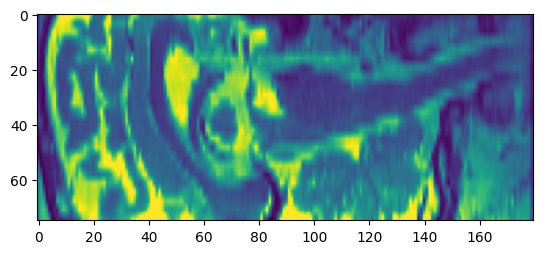

In [14]:
Z, H, W = imgs.shape
z_mid, h_mid, w_mid = Z//2, H//2, W//2
plt.imshow(imgs[:,:,w_mid])

In [15]:
row['PixelSpacing']

(0.3516, 0.3516)